In [129]:
import json
import string
from nltk.corpus import stopwords
import numpy as np
import pandas as pd
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = [12,9]
from gensim.models import KeyedVectors
import word2vecReader as godin_embedding
import fasttext
from keras.utils import to_categorical
from keras.models import Model
from keras.layers import Input,Dense,Flatten,Dropout,Embedding
from keras.layers.convolutional import Conv1D,MaxPooling1D
from keras.optimizers import Adam
from keras.layers.merge import concatenate
import keras.backend as K
from sklearn.model_selection import StratifiedKFold
from random import uniform,choice
from os import remove
import re
from sklearn.metrics import f1_score,precision_score,recall_score
import skopt
from skopt import gp_minimize, forest_minimize
from skopt.space import Real, Categorical, Integer
from skopt.utils import use_named_args
from pprint import pprint

In [130]:
def load_data_from_file(filename):
    with open(filename,'r') as fin:
        lines = fin.readlines()
    
    label = [int(x.split()[0]) for x in lines]
    sentence = [' '.join(x.split()[1:]) for x in lines]
    return label,sentence

In [131]:
label_train,sentence_train = load_data_from_file('dataset/sst2/stsa.binary.train')

In [132]:
label_dev,sentence_dev = load_data_from_file('dataset/sst2/stsa.binary.dev')

In [133]:
train_sentences = sentence_train+sentence_dev
train_labels = label_train+label_dev

In [134]:
len(train_sentences),len(train_labels)

(7792, 7792)

In [135]:
number_of_classes = len(set(train_labels))
number_of_classes

2

In [136]:
set(train_labels)

{0, 1}

In [137]:
for ele in list(set(train_labels)):
    print(train_labels.count(ele))

3738
4054


In [138]:
def clean_sentence(sentence):
    #removes links
    sentence = re.sub(r'(?P<url>https?://[^\s]+)', r'', sentence)
    # remove @usernames
    sentence = re.sub(r"\@(\w+)", "", sentence)
    #remove # from #tags
    sentence = sentence.replace('#','')
    # split into tokens by white space
    tokens = sentence.split()
    # remove punctuation from each token
    table = str.maketrans('', '', string.punctuation)
    tokens = [w.translate(table) for w in tokens]
    #for PYTHON 2.7
    #tokens = [w.translate(None, string.punctuation) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 1]
    tokens = ' '.join(tokens)
    return tokens

In [139]:
print("cleaning train data")
trainX = [clean_sentence(s) for s in train_sentences]
trainY = np.array(train_labels)

cleaning train data


In [140]:
length = [len(s.split()) for s in trainX]

30

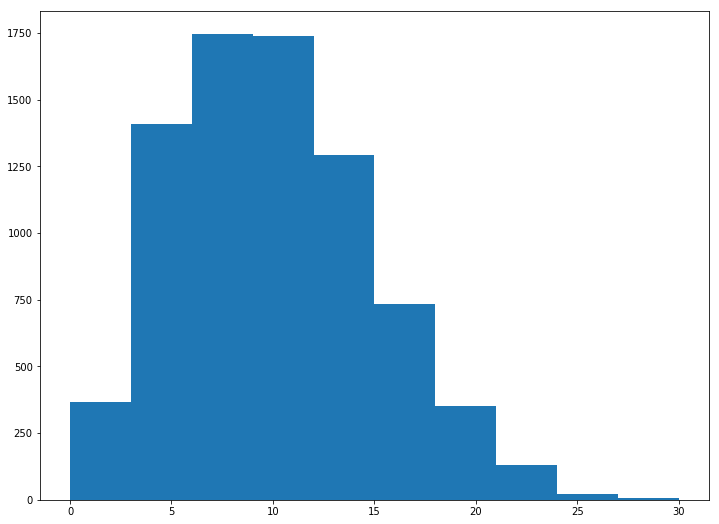

In [141]:
plt.hist(length)
max(length)

In [142]:
max_len = 25

In [143]:
def create_tokenizer(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [144]:
def encode_text(tokenizer, lines, length):
    encoded = tokenizer.texts_to_sequences(lines)
    padded = pad_sequences(encoded, maxlen=length, padding='post')
    return padded

In [145]:
#loading GloVe embedding
def load_GloVe_embedding(file_name):
    print('Loading GloVe word vectors.')
    embeddings_index = dict()
    f = open(file_name)
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()
    return embeddings_index

In [146]:
# create a weight matrix for words in training docs
def get_GloVe_embedding_matrix(embeddings_index):
    embedding_matrix = np.zeros((vocab_size, 300))
    for word, i in tokenizer.word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

In [147]:
#fast text word embedding
def load_fast_text_model(sentences):
    try:
        m = fasttext.load_model('word_embeddings/fast_text_model.bin')
        print("trained model loaded")
        return m
    except:
        print("traning new model")
        with open('temp_file.txt','w') as temp_file:
            for sentence in sentences:
                temp_file.write(sentence)
        m = fasttext.cbow('temp_file.txt','word_embeddings/fast_text_model')
        remove('temp_file.txt')
        print('model trained')
        return m

In [148]:
def get_fast_text_matrix(model):
    embedding_matrix = np.zeros((vocab_size,100))
    for word, i in tokenizer.word_index.items():
        try:
            embedding_vector = model[word]
        except KeyError:
            embedding_vector = None
        if embedding_vector is not None:
            embedding_matrix[i]=embedding_vector
    return embedding_matrix

In [149]:
#loading godin word embedding
def load_godin_word_embedding(path):
    print("Loading Goding model.")
    return godin_embedding.Word2Vec.load_word2vec_format(path, binary=True)

In [150]:
def get_godin_embedding_matrix(model):
    embedding_matrix = np.zeros((vocab_size,400))
    for word, i in tokenizer.word_index.items():
        try:
            embedding_vector = model[word]
        except KeyError:
            embedding_vector = None
        if embedding_vector is not None:
            embedding_matrix[i]=embedding_vector
    return embedding_matrix

In [151]:
#loading Google Word2Vec
def load_google_word2vec(file_name):
    print("Loading google news word2vec")
    return KeyedVectors.load_word2vec_format(file_name, binary=True)

In [152]:
def get_word2vec_embedding_matrix(model):
    embedding_matrix = np.zeros((vocab_size,300))
    for word, i in tokenizer.word_index.items():
        try:
            embedding_vector = model[word]
        except KeyError:
            embedding_vector = None
        if embedding_vector is not None:
            embedding_matrix[i]=embedding_vector
    return embedding_matrix

In [153]:
def define_model(length,vocab_size,n_dense,dropout,learning_rate,n_filters,filter_size,em,free_em_dim,number_of_classes):
    inputs = Input(shape=(length,))
    if em == 'free':
        embedding = Embedding(vocab_size, free_em_dim)(inputs)
    else:
        embedding = Embedding(vocab_size, len(eval(em)[0]), weights = [eval(em)],input_length=length,trainable = False)(inputs)
    
    conv = Conv1D(filters=n_filters, kernel_size=filter_size, activation='relu')(embedding)
    drop = Dropout(dropout)(conv)
    pool = MaxPooling1D(pool_size=2)(drop)
    flat = Flatten()(pool)
    # interpretation
    dense = Dense(n_dense, activation='relu')(flat)
    outputs = Dense(number_of_classes, activation='sigmoid')(dense)
    model = Model(inputs=inputs, outputs=outputs)
    # compile
    optimizer = Adam(lr=learning_rate)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    # summarize
    print(model.summary())
    return model

In [154]:
tokenizer = create_tokenizer(trainX)
vocab_size = len(tokenizer.word_index) + 1
print('Max document length: %d' % max_len)
print('Vocabulary size: %d' % vocab_size)
trainX = encode_text(tokenizer, trainX, max_len)

Max document length: 25
Vocabulary size: 15312


In [155]:
# glove_model = load_GloVe_embedding('word_embeddings/glove.6B.300d.txt')
# fast_text_model = load_fast_text_model(train_sentences)
# godin_model = load_godin_word_embedding("word_embeddings/word2vec_twitter_model.bin")
word2vec_model= load_google_word2vec('word_embeddings/GoogleNews-vectors-negative300.bin')

Loading google news word2vec


In [156]:
# embedding_matrix_glove = get_GloVe_embedding_matrix(glove_model)
embedding_matrix_word2vec = get_word2vec_embedding_matrix(word2vec_model)
# embedding_matrix_fast_text = get_fast_text_matrix(fast_text_model)
# embedding_matrix_godin = get_godin_embedding_matrix(godin_model)

In [157]:
seed = 7
np.random.seed(seed)

In [158]:
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)

In [159]:
para_learning_rate = Real(low=1e-4, high=1e-2, prior='log-uniform',name='learning_rate')

para_dropout = Real(low=0.4, high=0.9,name = 'dropout')

para_n_dense = Categorical(categories=[100,200,300,400], name='n_dense')

para_n_filters = Categorical(categories=[10,32,64,100,200],name='n_filters')

para_filter_size = Integer(low=1,high=8,name = 'filter_size')
para_em = Categorical(categories=['embedding_matrix_fast_text','embedding_matrix_godin','embedding_matrix_word2vec','embedding_matrix_glove','free'],name='em')

para_free_em_dim = Categorical(categories=[100,300,400],name='free_em_dim')

para_batch_size = Categorical(categories=[8,16,32,64],name='batch_size')

para_epoch = Categorical(categories=[10,20,50,100,150],name='epoch')


parameters = [para_learning_rate,para_dropout,para_n_dense,para_n_filters,para_filter_size,para_em,para_free_em_dim,para_batch_size,para_epoch]

default_parameters = [0.001,0.5777195655120914,100,32,3,'embedding_matrix_word2vec',100,64,10]


In [160]:
key = 1
record = {}

In [161]:
@use_named_args(dimensions=parameters)
def fitness(learning_rate,dropout,n_dense,n_filters,filter_size,em,free_em_dim,batch_size,epoch):
    global key
    global record
    global number_of_classes
    print('-----------------------------combination no={0}------------------'.format(key))
    parameters = {
            "n_dense": n_dense,
            "dropout": dropout,
            "learning_rate": learning_rate,
            "n_filters": n_filters,
            "filter_size": filter_size,
            "em": em,
            "free_em_dim": free_em_dim,
            "batch": batch_size,
            "epoch": epoch
        }
    
    pprint(parameters)
    
    itr = 1
    acc_record = []
    itr_record = {}
    for train,test in kfold.split(trainX,trainY):
        print("k fold validation itr == {0}".format(itr))
        X = trainX[train]
        Y = to_categorical(trainY[train],num_classes=number_of_classes)
        X_ = trainX[test]
        Y_ = to_categorical(trainY[test],num_classes=number_of_classes)
        model = define_model(length = max_len,
                             vocab_size=vocab_size,
                             n_dense = parameters["n_dense"],
                             dropout = parameters["dropout"],
                             learning_rate = parameters["learning_rate"],
                             n_filters = parameters["n_filters"],
                             filter_size = parameters["filter_size"],
                             em = parameters["em"],
                             free_em_dim = parameters["free_em_dim"],
                             number_of_classes = number_of_classes)
        history = model.fit(X,Y,validation_data = [X_,Y_],epochs=parameters["epoch"],batch_size=parameters["batch"])
        acc = history.history['val_acc'][-1]
        print(acc)
        acc_record.append(acc)
        itr_record[itr] = {}
        itr_record[itr]["acc"] = acc
        model.save('models/'+str(key)+'_'+str(itr)+'.h5')
        itr+=1
    record[key] = {}
    record[key]["parameter"] = parameters
    mean_acc = np.mean(acc_record)
    record[key]["mean_acc"] = mean_acc
    record[key]["itr_record"] = itr_record
    with open("models/record.json",'w')as fout:
        json.dump(record,fout,indent=4)
    key+=1
    
    del model
    K.clear_session()
    
    return -mean_acc

In [162]:
search_result = gp_minimize(func=fitness,
                            dimensions=parameters,
                            acq_func='EI',
                            n_calls=11,
                            x0=default_parameters)

-----------------------------combination no=1------------------
{'batch': 64,
 'dropout': 0.5777195655120914,
 'em': 'embedding_matrix_word2vec',
 'epoch': 10,
 'filter_size': 3,
 'free_em_dim': 100,
 'learning_rate': 0.001,
 'n_dense': 100,
 'n_filters': 32}
k fold validation itr == 1
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 25)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 25, 300)           4593600   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 23, 32)            28832     
_________________________________________________________________
dropout_1 (Dropout)          (None, 23, 32)            0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 11, 32)          

7012/7012 [==============================] - 2s 223us/step - loss: 0.3284 - acc: 0.8607 - val_loss: 0.4335 - val_acc: 0.8038
Epoch 7/10
7012/7012 [==============================] - 2s 224us/step - loss: 0.3151 - acc: 0.8613 - val_loss: 0.4346 - val_acc: 0.8058
Epoch 8/10
7012/7012 [==============================] - 2s 223us/step - loss: 0.2863 - acc: 0.8791 - val_loss: 0.4389 - val_acc: 0.8026
Epoch 9/10
7012/7012 [==============================] - 2s 223us/step - loss: 0.2729 - acc: 0.8860 - val_loss: 0.4663 - val_acc: 0.8000
Epoch 10/10
7012/7012 [==============================] - 2s 223us/step - loss: 0.2598 - acc: 0.8893 - val_loss: 0.4726 - val_acc: 0.7891
0.7891025641025641
k fold validation itr == 4
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 25)                0         
_________________________________________________________________
embedding_4 (Embeddi

7013/7013 [==============================] - 2s 227us/step - loss: 0.4230 - acc: 0.8084 - val_loss: 0.4056 - val_acc: 0.8049
Epoch 4/10
7013/7013 [==============================] - 2s 223us/step - loss: 0.3924 - acc: 0.8262 - val_loss: 0.3967 - val_acc: 0.8216
Epoch 5/10
7013/7013 [==============================] - 2s 225us/step - loss: 0.3631 - acc: 0.8428 - val_loss: 0.3842 - val_acc: 0.8248
Epoch 6/10
7013/7013 [==============================] - 2s 225us/step - loss: 0.3336 - acc: 0.8573 - val_loss: 0.3910 - val_acc: 0.8209
Epoch 7/10
7013/7013 [==============================] - 2s 226us/step - loss: 0.3189 - acc: 0.8619 - val_loss: 0.3943 - val_acc: 0.8196
Epoch 8/10
7013/7013 [==============================] - 2s 224us/step - loss: 0.2993 - acc: 0.8727 - val_loss: 0.4296 - val_acc: 0.7914
Epoch 9/10
7013/7013 [==============================] - 2s 226us/step - loss: 0.2749 - acc: 0.8838 - val_loss: 0.4050 - val_acc: 0.8074
Epoch 10/10
7013/7013 [==============================] - 2s

Train on 7014 samples, validate on 778 samples
Epoch 1/10
7014/7014 [==============================] - 2s 277us/step - loss: 0.5877 - acc: 0.6764 - val_loss: 0.5327 - val_acc: 0.7359
Epoch 2/10
7014/7014 [==============================] - 2s 224us/step - loss: 0.4533 - acc: 0.7924 - val_loss: 0.4873 - val_acc: 0.7603
Epoch 3/10
7014/7014 [==============================] - 2s 224us/step - loss: 0.4160 - acc: 0.8074 - val_loss: 0.4666 - val_acc: 0.7905
Epoch 4/10
7014/7014 [==============================] - 2s 226us/step - loss: 0.3842 - acc: 0.8275 - val_loss: 0.4665 - val_acc: 0.7873
Epoch 5/10
7014/7014 [==============================] - 2s 225us/step - loss: 0.3575 - acc: 0.8380 - val_loss: 0.4639 - val_acc: 0.7841
Epoch 6/10
7014/7014 [==============================] - 2s 228us/step - loss: 0.3340 - acc: 0.8579 - val_loss: 0.4637 - val_acc: 0.7860
Epoch 7/10
7014/7014 [==============================] - 2s 227us/step - loss: 0.3075 - acc: 0.8680 - val_loss: 0.4832 - val_acc: 0.7879
E

KeyboardInterrupt: 

Random hyperparameters

In [70]:
# def get_parameters():
#     #range values
#     para_n_dense = [100,200,300,400]
#     para_n_filters = [100,200,300,400]
#     para_filter_size = [1,2,3,4,5,6]
# #     para_em = ['embedding_matrix_fast_text','embedding_matrix_godin','embedding_matrix_word2vec','embedding_matrix_glove','free']
#     para_em = ['embedding_matrix_word2vec']
#     para_free_em_dim = [100,300,400]
#     para_em_trainable_flag = [True,False]
#     para_batch_size = [8,16,32,64]
# #     para_epoc = [10,30,60,100]
#     para_epoc = [10]
# #     para_batch_size = [64]
#     #selecting_random_value
#     parameters = {"n_dense": choice(para_n_dense),
#             "dropout": uniform(0.4, 0.9),
#             "learning_rate": uniform(0.0001, 0.01),
#             "n_filters": choice(para_n_filters),
#             "filter_size_c1": choice(para_filter_size),
#             "filter_size_c2": choice(para_filter_size),
#             "filter_size_c3": choice(para_filter_size),
#             "em_c1": choice(para_em),
#             "em_c2": choice(para_em),
#             "em_c3": choice(para_em),
#             "free_em_dim": choice(para_free_em_dim),
#             "em_trainable_flag_c1": choice(para_em_trainable_flag),
#             "em_trainable_flag_c2": choice(para_em_trainable_flag),
#             "em_trainable_flag_c3": choice(para_em_trainable_flag),
#             "batch": choice(para_batch_size),
#             "epoch": choice(para_epoc)
#         }
#     return parameters

Main loop

In [69]:
# for _ in range(number_of_models):
#     itr = 1
#     f1_record = []
#     p_record = []
#     r_record = []
#     itr_record = {}
#     parameters = get_parameters()
#     parameters = {
#             "n_dense": 400,
#             "dropout": 0.5777195655120914,
#             "learning_rate": 0.0071353667446707675,
#             "n_filters": 100,
#             "filter_size_c1": 6,
#             "filter_size_c2": 4,
#             "filter_size_c3": 4,
#             "em_c1": "embedding_matrix_word2vec",
#             "em_c2": "embedding_matrix_word2vec",
#             "em_c3": "embedding_matrix_word2vec",
#             "free_em_dim": 400,
#             "em_trainable_flag_c1": False,
#             "em_trainable_flag_c2": True,
#             "em_trainable_flag_c3": False,
#             "batch": 16,
#             "epoch": 1
#         }
#     print("model number {0}".format(key))
#     print(parameters)
#     for train,test in kfold.split(trainX,trainY):
#         print("k fold validation itr == {0}".format(itr))
#         X = trainX[train]
#         Y = to_categorical(trainY[train],num_classes=3)
#         X_ = trainX[test]
#         Y_ = list(trainY[test])
#         model = define_model(length = max_len,
#                              vocab_size=vocab_size,
#                              n_dense = parameters["n_dense"],
#                              dropout = parameters["dropout"],
#                              learning_rate = parameters["learning_rate"],
#                              n_filters = parameters["n_filters"],
#                              filter_size_c1 = parameters["filter_size_c1"],
#                              filter_size_c2 = parameters["filter_size_c2"],
#                              filter_size_c3 = parameters["filter_size_c3"],
#                              em_c1 = parameters["em_c1"],
#                              em_c2 = parameters["em_c1"],
#                              em_c3 = parameters["em_c1"],
#                              free_em_dim = parameters["free_em_dim"],
#                              em_trainable_flag_c1 = parameters["em_trainable_flag_c1"],
#                              em_trainable_flag_c2 = parameters["em_trainable_flag_c2"],
#                              em_trainable_flag_c3 = parameters["em_trainable_flag_c3"])
#         history = model.fit([X,X,X],Y,epochs=parameters["epoch"],batch_size=parameters["batch"])
#         pred = model.predict([X_,X_,X_])
#         pred_labels = [x.argmax() for x in pred]
#         for foo in zip(Y_[:50],pred_labels[:50]):
#             print(foo)
#         f1 = f1_score(Y_,pred_labels,labels=[0,1],average='micro')
#         p = precision_score(Y_,pred_labels,labels=[0,1],average='micro')
#         r = recall_score(Y_,pred_labels,labels=[0,1],average='micro')
#         print(f1,p,r)
#         f1_record.append(f1)
#         p_record.append(p)
#         r_record.append(r)
#         itr_record[itr] = {}
#         itr_record[itr]["f1"] = f1
#         itr_record[itr]["p"] = p
#         itr_record[itr]["r"] = r
#         model.save('models/'+str(key)+'_'+str(itr)+'.h5')
#         itr+=1
#     record[key] = {}
#     record[key]["parameter"] = parameters
#     record[key]["mean_f1"] = np.mean(f1_record)
#     record[key]["itr_record"] = itr_record

#     with open("models/record.json",'w')as fout:
#         json.dump(record,fout,indent=4)
#     key+=1